<a href="https://colab.research.google.com/github/simra-shahid/Hackerearth_Gala_Competition/blob/master/Gala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fastai

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
from fastai import *
from fastai.vision import * 
import pandas as pd
import numpy as np
import numpy as np 
import matplotlib.pyplot as plt
from google.colab import drive, files
from collections import Counter
import pandas as pd
from PIL import Image
from sklearn.metrics import f1_score
from collections import OrderedDict

In [0]:
np.random.seed(2)
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
path = "/gdrive/My Drive/Colab Notebooks/Gala Competition/dataset/"

In [0]:
train = pd.read_csv(path + "train.csv")
test  = pd.read_csv(path + "test.csv")

In [0]:
train.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [0]:
print("Train Images : ", len(train))
print("Test Images : " , len(test))

Train Images :  5983
Test Images :  3219


Undersampling

In [0]:
food = train[train["Class"]=="Food"]
food = food[:int(0.7 * len(food))]
len(food)

In [0]:
misc = train[train["Class"]=="misc"]
attire = train[train["Class"]=="Attire"]
decor = train[train["Class"]=="Decorationandsignage"]

train_undersampled = pd.concat([misc, food, decor, attire])
train_undersampled = train_undersampled.sample(frac = 1.0)

In [0]:
Counter(train["Class"])

In [0]:
Counter(train_undersampled["Class"])

In [0]:
print("Train Undersampled Images : ", len(train_undersampled))

**Removing Confusing Pictures**


# TRAINING

In [0]:
train_data = ImageDataBunch.from_df(path + 'Train Images',
                                    df = train,
                                    test = path + 'Test Images',
                                    label_col = 'Class',
                                    ds_tfms = get_transforms(), 
                                    size = 224)

In [0]:
train_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (4787 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Food,misc,Attire,Attire,misc
Path: /gdrive/My Drive/Colab Notebooks/Gala Competition/dataset/Train Images;

Valid: LabelList (1196 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
misc,misc,Food,Attire,Attire
Path: /gdrive/My Drive/Colab Notebooks/Gala Competition/dataset/Train Images;

Test: LabelList (3219 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /gdrive/My Drive/Colab Notebooks/Gala Competition/dataset/Train Images

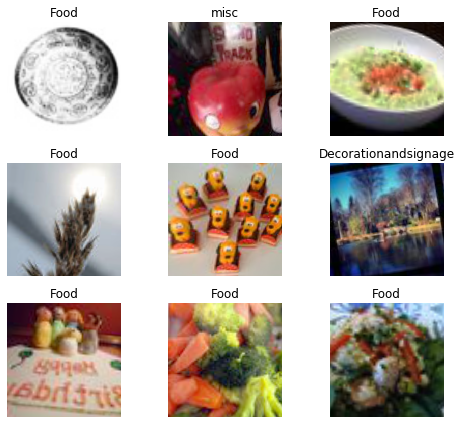

In [0]:
train_data.show_batch(rows = 3,figsize=(7,6))

In [0]:
len(train_data.classes), train_data.c

### Model Class A - Basic Resnet 34 and 50 

In [0]:
learn =  cnn_learner(train_data, models.resnet50, metrics = error_rate)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


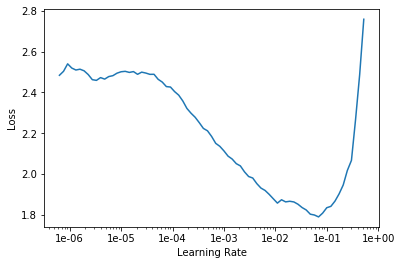

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,max_lr=slice(1e-2,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,1.494708,2.490020,0.353679,00:45
1,1.300280,1.476707,0.373746,00:45
2,1.033760,1.156210,0.341973,00:45
3,0.819514,0.663384,0.279264,00:45
4,0.650131,0.632935,0.234950,00:45


In [0]:
learn.save('model-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


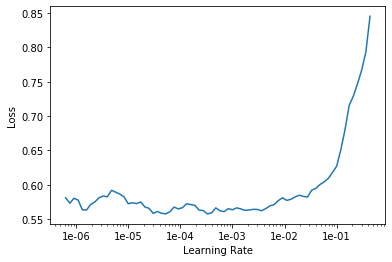

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5 ,max_lr=slice(1e-05,1e-04))

epoch,train_loss,valid_loss,error_rate,time
0,0.580930,0.736229,0.234950,00:48
1,0.570167,0.896136,0.243311,00:48
2,0.524142,0.593180,0.231605,00:48
3,0.469099,0.677776,0.221572,00:48
4,0.427060,0.760863,0.222408,00:48


## MODEL CLASS B  - Progressive Resizing






In [0]:
def get_data(size):
  data = ImageDataBunch.from_df(path + 'Train Images',
                                df = train,
                                test = path + 'Test Images',
                                label_col = 'Class',
                                ds_tfms = get_transforms(), 
                                size = size).normalize(imagenet_stats)
  return data

In [0]:
#learn64  =  cnn_learner(get_data(64) , models.resnet50, metrics = error_rate)
#learn128 =  cnn_learner(get_data(128), models.resnet50, metrics = error_rate)

In [0]:
data64  = get_data(64)
data128 = get_data(128)

In [0]:
learn = cnn_learner(data64, #training on low res first 
                    models.resnet18, #loading the resenet18 arch with pretrained weights
                    metrics = error_rate, 
                    model_dir='/tmp/model/') 

In [0]:
learn.lr_find() 
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, max_lr = slice(1e-02, 1e-01))

In [0]:
learn.data = data128
learn.unfreeze()

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-045,1e-029))

## Model Class C - Mixup Augmentation

In [0]:
learn = cnn_learner(train_data,
                    models.resnet50, 
                    metrics = error_rate).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


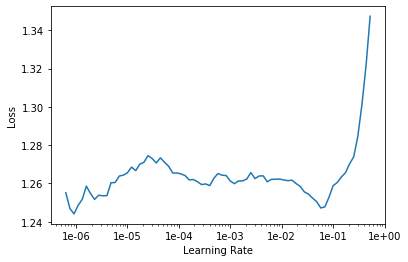

In [0]:
learn.lr_find() 
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, max_lr = slice(1e-014, 1e-012))

epoch,train_loss,valid_loss,error_rate,time
0,1.256664,9.757904,0.560201,01:07


In [0]:
learn.save('model-1')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr = slice(1e-02, 1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,1.467214,30.779734,0.718227,01:07
1,2.274663,47.646484,0.607860,01:07
2,1.705462,1.343538,0.645485,01:06
3,1.404010,1.869843,0.624582,01:06
4,1.289891,7.921062,0.558528,01:06


In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr = slice(1e-02, 1e-01))

In [0]:
learn.load('model-1')

# Model D - Alexnet

In [0]:
learn = cnn_learner(train_data,
                    models.alexnet, 
                    metrics = error_rate)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


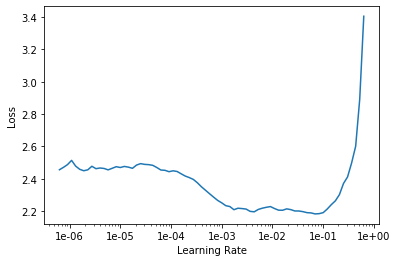

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-012)

epoch,train_loss,valid_loss,error_rate,time
0,2.499135,1.930186,0.744147,00:49


In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-012)

epoch,train_loss,valid_loss,error_rate,time
0,2.525314,1.904158,0.746656,00:50
1,2.514438,1.903205,0.745819,00:49
2,2.525917,1.905149,0.746656,00:48
3,2.528409,1.909035,0.749164,00:48
4,2.534256,1.888501,0.744147,00:47


In [0]:
learn.save('model-1')

# Model E - Vgg

In [0]:
learn = cnn_learner(train_data,
                    models.vgg16_bn, 
                    metrics = error_rate)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


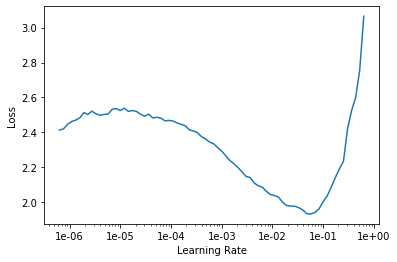

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-012)

epoch,train_loss,valid_loss,error_rate,time
0,2.469364,1.888801,0.740803,04:02


In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr = slice(1e-02, 1e-01))

epoch,train_loss,valid_loss,error_rate,time
0,2.253712,1235.838867,0.739967,00:54


KeyboardInterrupt: ignored

In [0]:
learn.save('model-1')

## TESTING & SUBMIT




In [0]:
valid_preds, _ = learn.get_preds()

In [0]:
valid_preds = [train_data.classes[np.argmax(i)] for i in valid_preds]

In [0]:
valid_targets = []
for i in train_data.valid_ds.items:
  valid_targets.append('image'+re.findall(r'\d+', str(i))[0]+'.jpg')

In [0]:
validation = pd.DataFrame(data = {'Image':valid_targets,'Predicted_Class':valid_preds})

In [0]:
valid = pd.merge(validation, train, on="Image", how = "left")

In [0]:
valid.head()

,Image,Predicted_Class,Class
0,image8056.jpg,misc,misc
1,image9603.jpg,misc,misc
2,image8571.jpg,Food,Food
3,image6801.jpg,Attire,Attire
4,image1350.jpg,Attire,Attire


In [0]:
print("Result on Validation : ", f1_score(valid["Predicted_Class"], valid["Class"], average = "weighted")*100)

Result on Validation :  78.21876060513127


In [0]:
test_targets = []
for i in train_data.test_ds.items:
  test_targets.append('image'+re.findall(r'\d+', str(i))[0]+'.jpg')

In [0]:
test_preds = []
for i in range(0,len(train_data.test_ds)):
    p = learn.predict(train_data.test_ds.x[i])
    test_preds.append(str(p[0]).lstrip('Category '))

In [0]:
len(test_preds), len(test_targets)

In [0]:
submission = pd.DataFrame(data = {'Image':test_targets,'Class':test_preds})

In [0]:
submit = pd.merge(test, submission, on="Image", how = "left")

In [0]:
Counter(submission["Class"])

In [0]:
submit.to_csv("test.csv", index = False)

In [0]:
submit.head()

In [0]:
files.download('test.csv') 

# RESULTS 
## MODEL CLASS A
* Model 1 - 80% resnet 34, no unfreezing 4 epochs
* Model 2 - 83.38000071843548% resnet 34,  unfreezing 4+2 epochs
* Model 3 - 79.90314317860381% resnet 50, no unfreezing 4 epochs
* Model 4 - 84.18093155748821% validation resnet 50, 2 unfreezing 5+2 epochs, 81% Test 
* Model 5 - 82.79093737145314% resnet 50, no unfreezing 5 epochs
* Model 6 - 86.2672122375352% resnet 50, unfreezing 5+5 epochs
* Model 7 - 86.50208583811634% resnet 50, unfreezing 5+5+5 epochs 82% on test

  ### Undersampling Food Class
* Model 8 - 72% resnet 50, unfreezing 5+5 epochs
* Model 8 - 83.17701701053413% resnet 50, unfreezing 5 epochs

## MODEL CLASS B 
* Model 1 - 31.44370884433082%, 51%

## MODEL CLASS C
* Alexnet - 24%
* Densenet - %

# Interpretation

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

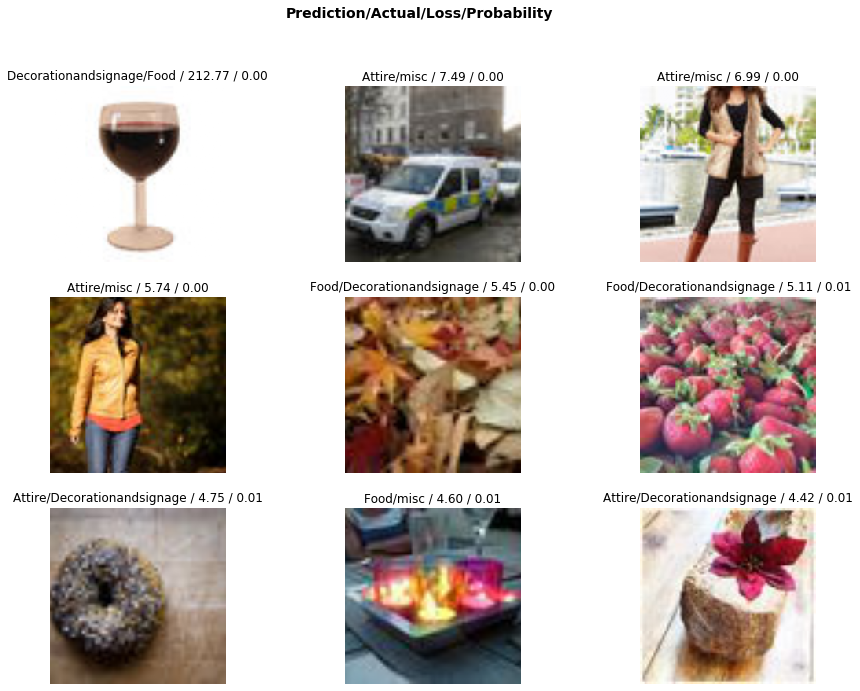

In [0]:
interp.plot_top_losses(9, figsize = (15,11))

In [0]:
doc(interp.plot_top_losses)

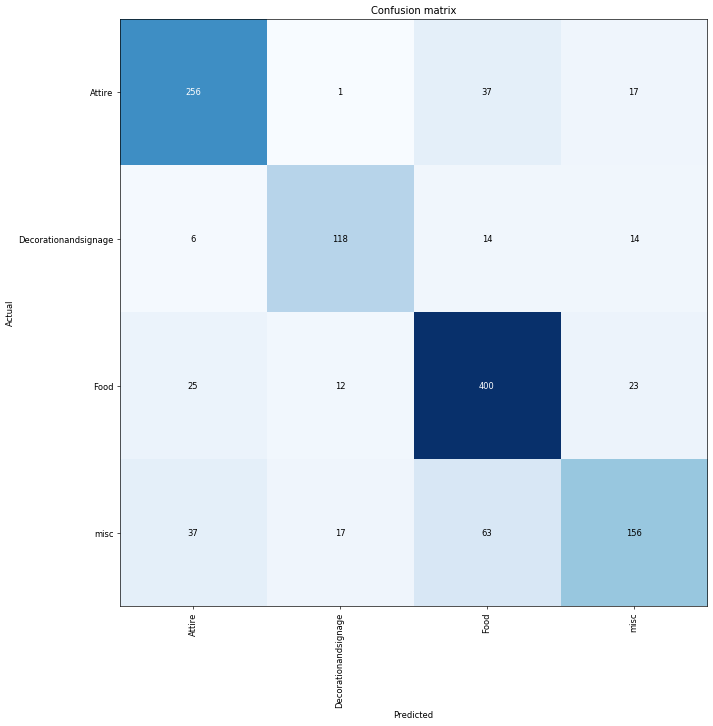

In [0]:
interp.plot_confusion_matrix(figsize = (12,12), dpi = 60 )

In [0]:
interp.most_confused(min_val = 2)

[('misc', 'Food', 63),
 ('Attire', 'Food', 37),
 ('misc', 'Attire', 37),
 ('Food', 'Attire', 25),
 ('Food', 'misc', 23),
 ('Attire', 'misc', 17),
 ('misc', 'Decorationandsignage', 17),
 ('Decorationandsignage', 'Food', 14),
 ('Decorationandsignage', 'misc', 14),
 ('Food', 'Decorationandsignage', 12),
 ('Decorationandsignage', 'Attire', 6)]

In [0]:
train["number"] = [ int(re.findall(r'\d+', i )[0]) for i in train["Image"]]

In [0]:
train.sort_values(by = ["number"], inplace = True)

In [0]:
train[-60:-40]

,Image,Class,number
163,image10802.jpg,Food,10802
3228,image10803.jpg,misc,10803
4559,image10805.jpg,Decorationandsignage,10805
1928,image10806.jpg,Food,10806
5847,image10807.jpg,Decorationandsignage,10807
2193,image10808.jpg,Attire,10808
4161,image10811.jpg,Attire,10811
596,image10812.jpg,Attire,10812
5175,image10814.jpg,Food,10814
180,image10815.jpg,Attire,10815


In [0]:
corrections = {'image10887.jpg': 'Decorations',
               'image10885': Decorations,
               'image10883': Decorations,
image10862.jpg	attire
image10856.jpg	Decor/ plants
image10843.jpg	Food
               }